# Libraries & Configurations

In [18]:
import os
import sys
from typing import Tuple, List
from glob import glob
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import multiprocessing as mp
import cv2
#from tqdm.notebook import tqdm
from time import time
import random
from enum import Enum

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.utils.data as data
import albumentations as A
from albumentations.pytorch import ToTensorV2

from torchvision import transforms
from torchvision.transforms import *

import timm
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, Subset, WeightedRandomSampler
from collections import defaultdict

In [34]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [35]:
train = pd.read_csv("./input/data/train/train.csv")
train

,id,gender,race,age,path
0,1,female,Asian,45,000001_female_Asian_45
1,2,female,Asian,52,000002_female_Asian_52
2,4,male,Asian,54,000004_male_Asian_54
3,5,female,Asian,58,000005_female_Asian_58
4,6,female,Asian,59,000006_female_Asian_59
...,...,...,...,...,...
2695,6954,male,Asian,19,006954_male_Asian_19
2696,6955,male,Asian,19,006955_male_Asian_19
2697,6956,male,Asian,19,006956_male_Asian_19
2698,6957,male,Asian,20,006957_male_Asian_20


In [36]:
train_img_dir = './input/data/train/images'

In [37]:
bounding_box = pd.read_csv('./bounding_box.csv')
bounding_box.set_index('img_paths', inplace=True)

# DataGeneration

## Define Dataset

In [38]:
### 마스크 여부, 성별, 나이를 mapping할 클래스를 생성합니다.

class MaskLabels(int, Enum):
    MASK = 0
    INCORRECT = 1
    NORMAL = 2


class GenderLabels(int, Enum):
    MALE = 0
    FEMALE = 1

    @classmethod
    def from_str(cls, value: str) -> int:
        value = value.lower()
        if value == "male":
            return cls.MALE
        elif value == "female":
            return cls.FEMALE
        else:
            raise ValueError(f"Gender value should be either 'male' or 'female', {value}")


class AgeLabels(int, Enum):
    YOUNG = 0
    MIDDLE = 1
    OLD = 2

    @classmethod
    def from_number(cls, value: str) -> int:
        try:
            value = int(value)
        except Exception:
            raise ValueError(f"Age value should be numeric, {value}")

        if value < 30:
            return cls.YOUNG
        elif value < 60:
            return cls.MIDDLE
        else:
            return cls.OLD

In [58]:
class MaskBaseDataset(data.Dataset):
    num_classes = 3 * 2 * 3

    _file_names = {
        "mask1": MaskLabels.MASK,
        "mask2": MaskLabels.MASK,
        "mask3": MaskLabels.MASK,
        "mask4": MaskLabels.MASK,
        "mask5": MaskLabels.MASK,
        "incorrect_mask": MaskLabels.INCORRECT,
        "normal": MaskLabels.NORMAL
    }

    image_paths = []
    mask_labels = []
    gender_labels = []
    age_labels = []

    def __init__(self, data_dir, mean=(0.56, 0.524, 0.501), std=(0.233, 0.243, 0.246), val_ratio=0.2):
        self.data_dir = data_dir
        self.mean = mean
        self.std = std
        self.val_ratio = val_ratio
        self.indices = defaultdict(list)
        
        self.setup()
        self.calc_statistics()
        
        
    @staticmethod
    def _split_profile(profiles, val_ratio):
        total_len = len(profiles)
        n_val = int(total_len * val_ratio)
        total_indices = range(total_len)
        val_indices = set(random.choices(total_indices, k=n_val))
        train_indices = set(total_indices) - val_indices
        
        return {"train": train_indices, "val": val_indices}
    
    def setup(self):
        profiles = os.listdir(self.data_dir)
        profiles = [profile for profile in profiles if not profile.startswith(".")]
        split_profiles = self._split_profile(profiles, self.val_ratio)

        cnt = 0
        for phase, indices in split_profiles.items():
            for _idx in indices:
                profile = profiles[_idx]
                img_folder = os.path.join(self.data_dir, profile)
                for file_name in os.listdir(img_folder):
                    _file_name, ext = os.path.splitext(file_name)
                    if _file_name not in self._file_names:  # "." 로 시작하는 파일 및 invalid 한 파일들은 무시합니다
                        continue

                    img_path = os.path.join(self.data_dir, profile, file_name)
                    mask_label = self._file_names[_file_name]

                    id, gender, race, age = profile.split("_")
                    if (27 < int(age) < 30) or (57 < int(age) < 60) :
                        continue
                    gender_label = GenderLabels.from_str(gender)
                    age_label = AgeLabels.from_number(age)

                    self.image_paths.append(img_path)
                    self.mask_labels.append(mask_label)
                    self.gender_labels.append(gender_label)
                    self.age_labels.append(age_label)

                    self.indices[phase].append(cnt)
                    cnt += 1
    
    def split_dataset(self) -> List[Subset]:
        return [Subset(self, indices) for phase, indices in self.indices.items()]
    
    def get_sampler(self, phase) :
        _multi_class = []
        for _idx in self.indices[phase]:
            _multi_class.append(self.encode_multi_class(self.mask_labels[_idx], self.gender_labels[_idx], self.age_labels[_idx]))
        
        size = len(_multi_class)
        class_counts = pd.DataFrame(_multi_class).value_counts().to_list()        
        class_weights = [size / class_counts[i] for i in range(len(class_counts))] #클래스별 가중치 부여
        weights = [class_weights[_multi_class[i]] for i in range(size)]            #해당 레이블마다의 가중치 비율
        sampler = WeightedRandomSampler(torch.DoubleTensor(weights), size)
    
        return sampler

    def calc_statistics(self):
        has_statistics = self.mean is not None and self.std is not None
        if not has_statistics:
            print("[Warning] Calculating statistics... It can take a long time depending on your CPU machine")
            sums = []
            squared = []
            for image_path in self.image_paths[:3000]:
                image = np.array(Image.open(image_path)).astype(np.int32)
                sums.append(image.mean(axis=(0, 1)))
                squared.append((image ** 2).mean(axis=(0, 1)))

            self.mean = np.mean(sums, axis=0) / 255
            self.std = (np.mean(squared, axis=0) - self.mean ** 2) ** 0.5 / 255

    def set_train_transform(self, transform):
        self.train_transform = transform
        
    def set_val_transform(self, transform):
        self.val_transform = transform

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path)
        image = np.array(image)
        # Face detect
        if sum(bounding_box.loc['/opt/ml'+image_path[1:],]):
            x_min, y_min, x_max, y_max = bounding_box.loc['/opt/ml'+image_path[1:],]
            image = image[int(y_min):int(y_max), int(x_min):int(x_max)]
        else:
            image = Image.open(self.image_paths[index])
            image = CenterCrop(300)(image)
            
        mask_label = self.get_mask_label(index)
        gender_label = self.get_gender_label(index)
        age_label = self.get_age_label(index)
        multi_class_label = self.encode_multi_class(mask_label, gender_label, age_label)
        
        if index in self.indices["train"]:
            image_transform =  self.train_transform(image = np.array(image))["image"]
        else:
            image_transform =  self.val_transform(image = np.array(image))["image"]

        return image_transform, multi_class_label

    def __len__(self):
        return len(self.image_paths)

    def get_mask_label(self, index) -> MaskLabels:
        return self.mask_labels[index]

    def get_gender_label(self, index) -> GenderLabels:
        return self.gender_labels[index]

    def get_age_label(self, index) -> AgeLabels:
        return self.age_labels[index]

    @staticmethod
    def encode_multi_class(mask_label, gender_label, age_label) -> int:
        return mask_label * 6 + gender_label * 3 + age_label

    @staticmethod
    def decode_multi_class(multi_class_label) -> Tuple[MaskLabels, GenderLabels, AgeLabels]:
        mask_label = (multi_class_label // 6) % 3
        gender_label = (multi_class_label // 3) % 2
        age_label = multi_class_label % 3
        return mask_label, gender_label, age_label

    @staticmethod
    def denormalize_image(image, mean, std):
        img_cp = image.copy()
        img_cp *= std
        img_cp += mean
        img_cp *= 255.0
        img_cp = np.clip(img_cp, 0, 255).astype(np.uint8)
        return img_cp

In [59]:
dataset = MaskBaseDataset(data_dir=train_img_dir)

In [60]:
n_val = int(len(dataset) * 0.3)
n_train = len(dataset) - n_val
train_dataset, val_dataset = data.random_split(dataset, [n_train, n_val])

In [164]:
train_transform = A.Compose([
        A.CLAHE(p=1, clip_limit=3.0),
        A.ColorJitter(0.1, 0.1, 0.1, 0.1),
        A.GaussNoise(p=1, var_limit=(0.0, 25)),
        A.GridDistortion(p=1, distort_limit=(-0.02, 0.05)),
        A.ISONoise(),
        A.ElasticTransform(p=1, alpha=0.2, sigma=3, alpha_affine=2),
        A.Resize(height=224, width=224),
        A.CoarseDropout(p=1, max_holes=20, max_height=10, max_width=15, min_holes=1, min_height=5, min_width=5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.56, 0.524, 0.501), std=(0.233, 0.243, 0.246)),
        ToTensorV2(),
])
    
val_transform = A.Compose([
        A.CLAHE(p=1, clip_limit=3.0),
        A.Resize(height=224, width=224),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.56, 0.524, 0.501), std=(0.233, 0.243, 0.246)),
        ToTensorV2(),
]) 

In [165]:
train_dataset.dataset.set_train_transform(train_transform)
val_dataset.dataset.set_val_transform(val_transform)

In [166]:
def rand_bbox(size, lam):
    W = size[2] // 2  # 절반 위만 되도록 수정 (먀스크 윗부분)
    H = size[3] 
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 5, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 5, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
    
class CutMix(object):
    def __init__(self, beta, cutmix_prob) -> None:
        super().__init__()
        self.beta = beta
        self.cutmix_prob = cutmix_prob
        
    def forward(self, images, labels):
        lam = np.random.beta(self.beta, self.beta)
        rand_index = torch.randperm(images.size()[0])
        label_1 = labels
        label_2 = labels[rand_index]
        bbx1, bby1, bbx2, bby2 = rand_bbox(images.size(), lam)
        images[:, :, bbx1:bbx2, bby1:bby2] = images[rand_index, :, bbx1:bbx2, bby1:bby2]
        
        lam = 1 - ((bbx2-bbx1)*(bby2-bby1)/(images.size()[-1]*images.size()[-2]))
        
        return {'lam': lam, 'image': images, 'label_1': label_1, 'label_2': label_2}

## Aug 결과 예시 데이터

In [167]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True,
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=64,
    num_workers=0,
    shuffle=True,
)

In [176]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([64, 3, 224, 224])
labels shape: torch.Size([64])


In [177]:
cutmix_prob = 0.5
cutmix = CutMix(beta=1.0, cutmix_prob=cutmix_prob)

In [178]:
images = cutmix.forward(images, labels)['image']

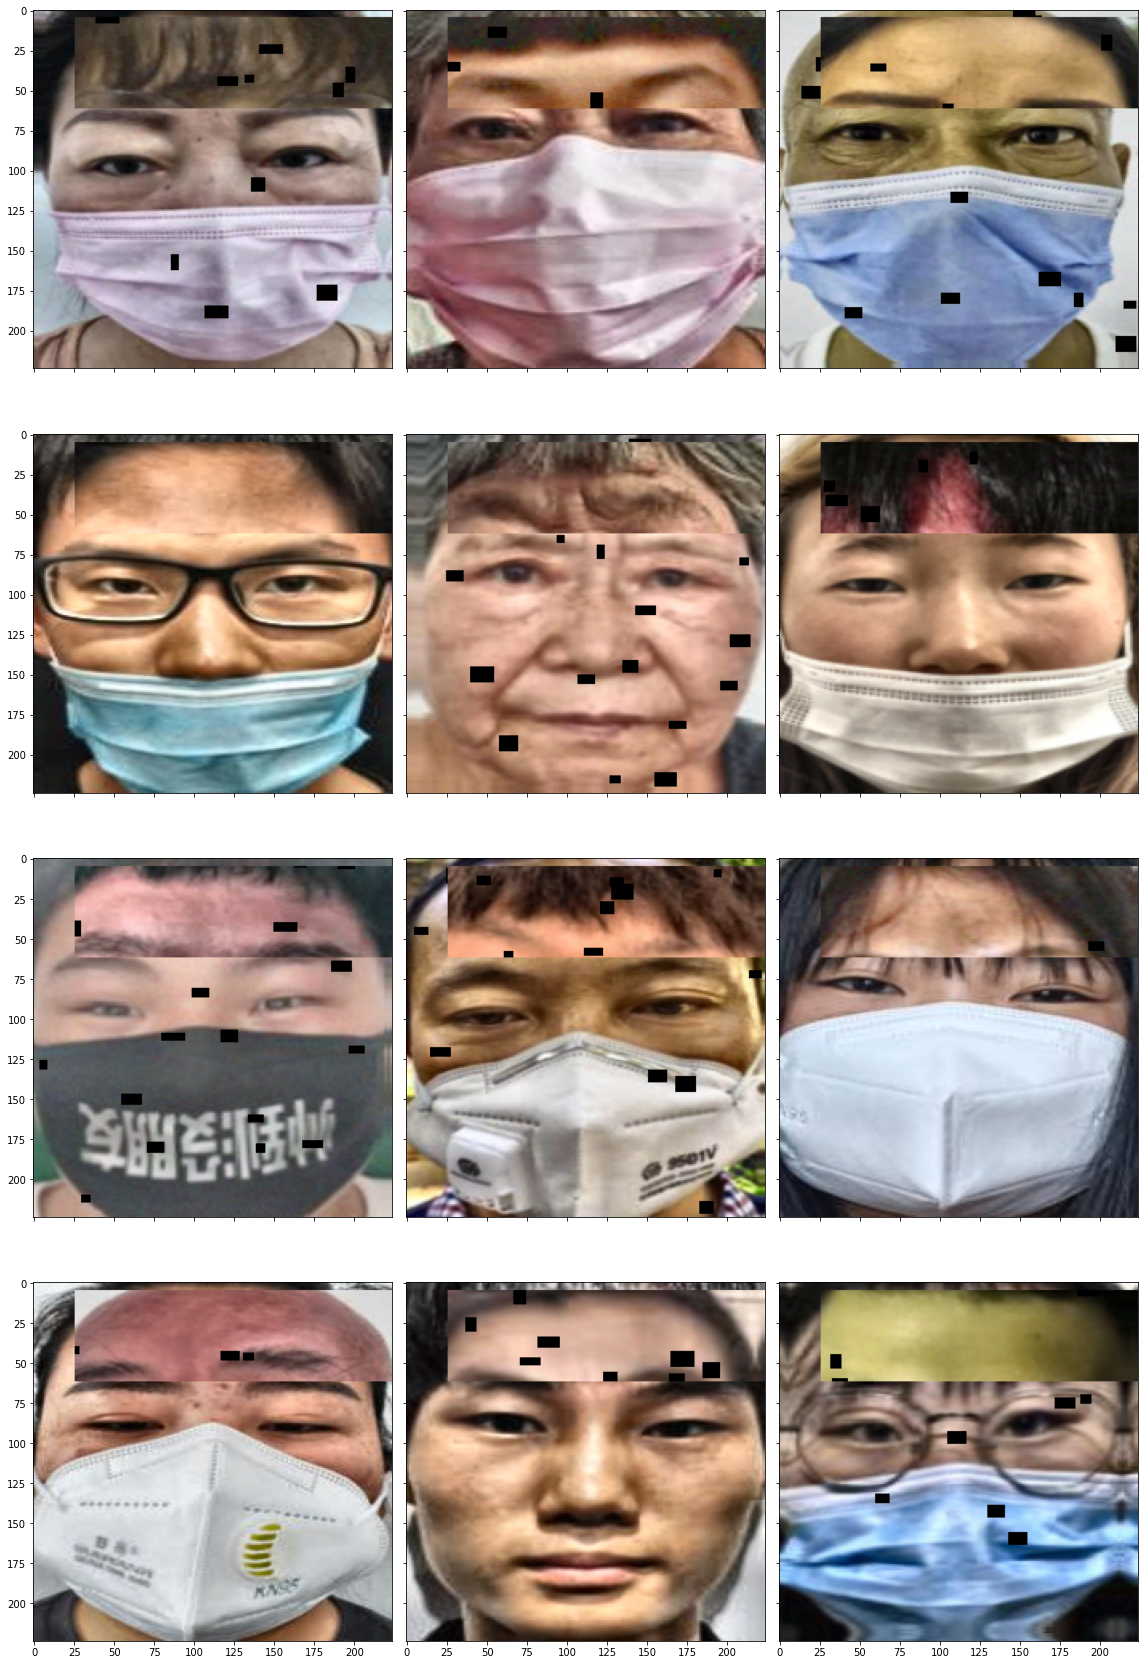

In [179]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip((0.56, 0.524, 0.501), (0.233, 0.243, 0.246))],
    std=[1 / s for s in (0.233, 0.243, 0.246)]
)

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    #axes[i%n_rows][i//(n_cols+1)].set_title(f'Label: {labels[i]}', color='r')
plt.tight_layout()